# PicTex Text Detection Model with Zach

From meeting with Zach on 8/10/20 because `output tensors` weren't 1's and 0's


### 1. Create labels

In [30]:
from collections import OrderedDict
import numpy as np
import torch
import os

data_dir = "./our_images_final/"

classes = os.listdir(data_dir)
num_classes = len(classes)

classes_encode, classes_decode = {}, {}
for i, name in enumerate(classes):
    classes_encode[name] = i
    classes_decode[i] = name

encode_dict, decode_dict = OrderedDict(classes_encode), OrderedDict(classes_encode)

print(f"There are {num_classes} classes")
print(classes_encode)
print(classes_decode)

There are 42 classes
{'(': 0, ')': 1, '+': 2, ',': 3, '=': 4, 'a': 5, 'ast': 6, 'b': 7, 'c': 8, 'cong': 9, 'd': 10, 'e': 11, 'f': 12, 'full_stop': 13, 'g': 14, 'geq': 15, 'h': 16, 'i': 17, 'iff': 18, 'implies': 19, 'j': 20, 'k': 21, 'l': 22, 'leq': 23, 'm': 24, 'minus': 25, 'n': 26, 'neq': 27, 'o': 28, 'p': 29, 'plus': 30, 'q': 31, 'r': 32, 's': 33, 'sum': 34, 't': 35, 'u': 36, 'v': 37, 'w': 38, 'x': 39, 'y': 40, 'z': 41}
{0: '(', 1: ')', 2: '+', 3: ',', 4: '=', 5: 'a', 6: 'ast', 7: 'b', 8: 'c', 9: 'cong', 10: 'd', 11: 'e', 12: 'f', 13: 'full_stop', 14: 'g', 15: 'geq', 16: 'h', 17: 'i', 18: 'iff', 19: 'implies', 20: 'j', 21: 'k', 22: 'l', 23: 'leq', 24: 'm', 25: 'minus', 26: 'n', 27: 'neq', 28: 'o', 29: 'p', 30: 'plus', 31: 'q', 32: 'r', 33: 's', 34: 'sum', 35: 't', 36: 'u', 37: 'v', 38: 'w', 39: 'x', 40: 'y', 41: 'z'}


### 2. Create the `Dataset` and `Dataloader` objects

In [44]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import random_split
import numpy as np
import torch
from PIL import Image

# Choose either colored / grayscale
num_output_channels = 1
normal = (0.5,) # uncomment this for grayscale
# normal = (0.5, 0.5, 0.5) # uncomment this for colored

# choose batch size
batch_size = 64

transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels),
     transforms.Resize((32, 32)), 
     transforms.ToTensor(),
     transforms.Normalize(normal, normal)])

class PicTexDataset(Dataset):
    def __init__(self, root_dir, encode_dict, num_classes, transform=None):
        """
        Args:
            root_dir (string): Directory containing images sorted by class folders
            encode_dict (Ordered dict): Dictionary with class names zipped from 0-(num_classes-1)
            num_classes (int): Number of classes (SHOULD EQUAL LEN of ENCODE_DICT)
            transform (torchvision.transforms): Transforms to be applied to images 
        """
        self.root_dir = root_dir
        self.encode_dict = encode_dict
        self.num_classes = num_classes
        self.transform = transform
        
        """
        Loading images:
            all_paths (string list): Path of every image
            all_paths_class (string list): Bijection with all_paths. Class name for each path
            all_images (string * string list): List of these objects... (class name, path of image)
        """
        all_paths, all_paths_class = [], []
        for name in encode_dict.keys():
            list_classes = os.listdir(root_dir + name)
            all_paths += list(map(lambda s : root_dir + name + "/" + s, list_classes))
            all_paths_class += [name] * len(list_classes)
        
        self.all_images = list(zip(all_paths_class, all_paths))

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_class, img_name = self.all_images[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        # image = image.unsqueeze(1)
        
        #label = torch.zeros(self.num_classes)
        #label[self.encode_dict[img_class]] = 1 
        label = self.encode_dict[img_class]
        
        return image, label
    
def load_split_train_test(datadir, valid_size = .2):
    dataset = PicTexDataset(data_dir, encode_dict, num_classes, transform)
    num_test = int(valid_size*len(dataset))
    num_train = len(dataset) - num_test
    
    train_data, test_data = random_split(dataset, (num_train, num_test))
    
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)


### 3. Test `Dataloader`

In [51]:
for image, label in trainloader:
    print(f"Label: {label}")

Label: tensor([29, 39, 28, 10, 21, 36, 35, 10, 14, 39, 29, 17, 32, 28, 35, 24, 10, 17,
        18, 36, 16, 22, 29, 39, 41, 28,  6, 17, 39, 38, 14, 17, 37, 38, 26, 14,
        14,  8, 39, 39, 28, 24, 20, 17, 22, 35, 21, 16,  4, 22, 16, 28, 25, 19,
        14,  3, 12, 20, 41, 35, 41, 41,  8, 24])
Label: tensor([21, 40, 20, 19,  9, 34, 37, 16, 33, 22, 29, 10,  4, 14, 26, 33, 12, 21,
        28, 40, 16, 25, 12, 39, 16, 35, 37, 35,  7,  3, 14, 31, 25, 32,  8, 13,
         8, 37,  5,  4, 24,  5, 31, 14, 40, 25, 19, 30, 38, 20,  8, 20, 19, 33,
        16, 32, 29, 19, 16,  1, 20, 21, 26, 16])
Label: tensor([39,  8,  4, 32, 24, 33, 18, 34, 25, 29, 19, 12,  5, 36,  6, 39, 36, 23,
        39, 29, 20, 33, 17, 17, 13, 38,  3, 25, 18, 20, 30,  3, 16, 28, 34, 22,
        33,  8, 28, 34, 32, 37, 20, 12, 19, 20, 33,  7, 22, 29, 32,  1, 35, 16,
        33, 29, 28, 11, 34,  4, 39,  5, 16, 22])
Label: tensor([36, 19, 20, 17, 36, 18, 24, 26, 12, 35, 39,  4,  2, 24, 33, 31,  6, 19,
        28, 21, 41, 41,  

Label: tensor([19, 35, 20, 29,  4, 14, 19,  3, 20,  1, 38,  3, 29,  7, 15,  5, 29, 40,
        19, 24, 12, 35,  9, 17, 17, 25, 21, 14, 11, 26, 29, 32, 25,  2, 20, 28,
        19, 34, 23, 26, 29, 26, 28, 39, 29, 34, 30, 33, 37, 30, 38,  5, 41,  7,
        16, 28, 31,  1, 10, 28,  6, 20, 37, 21])
Label: tensor([22, 40, 32, 26, 12,  1, 12,  5,  4, 30, 28, 14, 25, 12, 14, 37,  3,  7,
         8, 30, 16, 35,  3, 27, 34, 34, 34, 32, 25, 12, 29, 25, 39,  4, 15, 21,
        16, 29, 21, 16, 39, 34, 39, 32, 24,  3, 20, 25,  7, 19, 26, 33, 16, 14,
        14, 28, 15,  5, 20,  1, 35, 17, 20, 24])
Label: tensor([22, 26, 22, 26, 19, 39, 23, 17,  7, 14, 40, 16, 26, 12, 28, 10,  7, 20,
        25, 38, 36, 40, 21, 37, 12, 22, 39, 26,  4, 22, 37, 20, 26, 17, 22,  4,
        29,  4, 28, 33,  5, 16, 26, 34,  9,  7, 32, 29, 39, 21, 37, 38, 19, 22,
        39, 41,  0, 25, 15, 32, 39,  9,  8,  5])
Label: tensor([25, 26,  2, 37, 10, 16, 21, 17, 14, 26, 33, 20, 41, 33, 28, 41, 34, 39,
         8, 25, 29, 12,  

### 4. Everything else from before:

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=42, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (soft): LogSoftmax()
)
NLLLoss()
Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.002
    weight_decay: 0
)
========================================BEGIN TRAINING=======================================


c:\users\zacan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


|  [Epoch: 1, Batch: 10]   Train loss: 0.630  |  Test loss: 3.451  |  Test accuracy: 0.087  |
|  [Epoch: 1, Batch: 20]   Train loss: 0.621  |  Test loss: 3.393  |  Test accuracy: 0.053  |
|  [Epoch: 1, Batch: 30]   Train loss: 0.607  |  Test loss: 3.305  |  Test accuracy: 0.022  |
|  [Epoch: 1, Batch: 40]   Train loss: 0.591  |  Test loss: 3.178  |  Test accuracy: 0.043  |
|  [Epoch: 1, Batch: 50]   Train loss: 0.564  |  Test loss: 3.008  |  Test accuracy: 0.042  |
|  [Epoch: 2, Batch: 10]   Train loss: 0.998  |  Test loss: 2.660  |  Test accuracy: 0.036  |
|  [Epoch: 2, Batch: 20]   Train loss: 0.472  |  Test loss: 2.502  |  Test accuracy: 0.045  |
|  [Epoch: 2, Batch: 30]   Train loss: 0.445  |  Test loss: 2.345  |  Test accuracy: 0.017  |
|  [Epoch: 2, Batch: 40]   Train loss: 0.444  |  Test loss: 2.273  |  Test accuracy: 0.031  |
|  [Epoch: 2, Batch: 50]   Train loss: 0.411  |  Test loss: 2.176  |  Test accuracy: 0.044  |
|  [Epoch: 3, Batch: 10]   Train loss: 0.732  |  Test loss: 

|  [Epoch: 18, Batch: 30]   Train loss: 0.092  |  Test loss: 0.485  |  Test accuracy: 0.026  |
|  [Epoch: 18, Batch: 40]   Train loss: 0.081  |  Test loss: 0.462  |  Test accuracy: 0.026  |
|  [Epoch: 18, Batch: 50]   Train loss: 0.075  |  Test loss: 0.470  |  Test accuracy: 0.026  |
|  [Epoch: 19, Batch: 10]   Train loss: 0.147  |  Test loss: 0.442  |  Test accuracy: 0.021  |
|  [Epoch: 19, Batch: 20]   Train loss: 0.089  |  Test loss: 0.471  |  Test accuracy: 0.023  |
|  [Epoch: 19, Batch: 30]   Train loss: 0.077  |  Test loss: 0.453  |  Test accuracy: 0.028  |
|  [Epoch: 19, Batch: 40]   Train loss: 0.085  |  Test loss: 0.497  |  Test accuracy: 0.026  |
|  [Epoch: 19, Batch: 50]   Train loss: 0.080  |  Test loss: 0.461  |  Test accuracy: 0.023  |
|  [Epoch: 20, Batch: 10]   Train loss: 0.156  |  Test loss: 0.490  |  Test accuracy: 0.026  |
|  [Epoch: 20, Batch: 20]   Train loss: 0.076  |  Test loss: 0.465  |  Test accuracy: 0.028  |
|  [Epoch: 20, Batch: 30]   Train loss: 0.077  |  

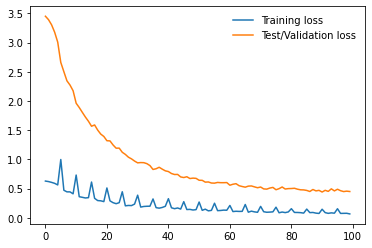

In [68]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(num_output_channels, 6, 5)
        self.pool = nn.MaxPool2d(2, 2) # idk what this does
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Transitioning from Conv ===> Linear
        # 16 is the number of output channels in the previous conv layer.
        # not sure what 5 is...
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))
        self.drop = nn.Dropout(0.1)
        self.soft = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.drop(x)
        x = self.soft(x)
        return x

# init the class 
model = Net()
print(model)

import torch.optim as optim

# set parameters
learning_rate = 0.002
momentum = 0.9

def loss_optim():
    # criterion = nn.CrossEntropyLoss()
    # criterion = nn.MSELoss()
    criterion = nn.NLLLoss()
    # Adam Max
    optimizer = torch.optim.Adamax(model.parameters(), learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    # Adam
    # optimizer = optim.Adam(model.parameters(), learning_rate)
    # SGD. Momentum = remembering previous estimation change for a param (delta W)
    # optimizer = optim.SGD(model.parameters(), learning_rate, momentum)
    return criterion, optimizer

criterion, optimizer = loss_optim()
print(criterion)
print(optimizer)

%matplotlib inline
import matplotlib.pyplot as plt
from torch.autograd import Variable


def train_network():
    
    # Choose parameters
    num_epoch = 20
    mini_batch = 10 # previously batch_size
    train_losses, test_losses = [], []
    running_loss = 0
    for epoch in range(num_epoch):  # loop over the dataset multiple times
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            # convert to float bc softmax doesn't work with long
            inputs = torch.tensor(inputs, dtype=torch.float)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # print statistics
            if i % mini_batch == mini_batch-1:    # print every # of mini-batches
                test_loss = 0
                accuracy = 0
                # begin evaluation of validation loss
                model.eval()
                with torch.no_grad():
                    for inputs_test, labels_test in testloader:
                        if labels_test.size()[0] == 64:
                            logps = model.forward(inputs_test)
                            batch_loss = criterion(logps, labels_test)
                            test_loss += batch_loss.item()
                            ps = torch.exp(logps)
                            top_p, top_class = ps.topk(1, dim=1)
                            equals = top_class == labels.view(*top_class.shape)
                            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))    
                print(f"|  [Epoch: {epoch + 1}, Batch: {i + 1}]   "
                      f"Train loss: {running_loss/len(trainloader):.3f}  |  "
                      f"Test loss: {test_loss/len(testloader):.3f}  |  "
                      f"Test accuracy: {accuracy/len(testloader):.3f}  |")
                running_loss = 0
                model.train()
            
    
    PATH = './models/custom_label_100.pt'
    torch.save(model.state_dict(), PATH)
    return train_losses, test_losses, PATH

def visualize_train(train_losses, test_losses):
     plt.plot(train_losses, label='Training loss')
     plt.plot(test_losses, label='Test/Validation loss')
     plt.legend(frameon=False)
     plt.show()

print("========================================BEGIN TRAINING=======================================")
train_losses, test_losses, PATH = train_network()
print("=========================================END TRAINING========================================")
visualize_train(train_losses, test_losses)